In [2]:
# %pip install healpy
# %pip install astropy
import healpy as hp
import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.coordinates import SkyCoord

In [3]:
# Read in 22.5 million data elements
data = pd.read_csv('/Users/monicahicks/GLADE+512.csv')
# Print first 5 row for format check
data.head(5)

,G_or_Q,RA,DEC,Pix,Z
0,G,192.721451,41.120152,538552,0.000991
1,G,188.860123,14.496320,1179597,0.004120
2,G,267.360474,70.144341,93102,0.001000
3,G,187.016220,9.803620,1304536,0.003557
4,G,187.367000,8.749890,1333206,0.004139


In [4]:
# This is SO FREAKING FAST literally 1000x faster than a loop
good_data = data.loc[(data.Z < 0.25) & (data.Z > 0)]

In [5]:
# sanity check on elements in desired set
print(len(good_data))

15780980


In [6]:
# get galaxy icrs coordinates from RA/Dec coordinates
# creates 3 equal length paralell arrays
ra = good_data['RA']
dec = good_data['DEC']
coords = SkyCoord(ra=ra, dec=dec, unit="deg", frame='icrs')

In [7]:
# get parallel arrays of galaxy location as vector and pixel coordinates
# vec is list of 3-element vectors: [[x1,y1,z1], ... [xn,yn,zn]]
vec = hp.ang2vec(theta=np.pi / 2.0 - np.radians(coords.galactic.b.value), phi=np.radians(coords.galactic.l.value),lonlat=False)
# pixels is list of integers 0-50331647
pixels = hp.ang2pix(nside=2048,theta=np.pi / 2.0 - np.radians(coords.galactic.b.value), phi=np.radians(coords.galactic.l.value),lonlat=False)

In [8]:
z = good_data['Z']
print(len(z))

15780980


We now have parallel arrays of vector location, pixel, and z value

In [9]:
# create dividers for 16 bins 0-0.25
def get_z_bin(z):
    bins = np.linspace(0,0.25,17)
    for i in range(len(bins)):
        # skip 0 to set it as bin floor
        if z < bins[i]:
            return i - 1
    return 15

In [10]:
# test proper binning
print(0.07,get_z_bin(0.07))
print(0.091,get_z_bin(0.091))
print(0.05,get_z_bin(0.05))
print(0.04,get_z_bin(0.04))
print(0.21,get_z_bin(0.21))

0.07 4
0.091 5
0.05 3
0.04 2
0.21 13


In [ ]:
# create map with pixel as key
# [ z-bins, vector location, red value, expected red value ]
# as value
pixel_dict = {}
# set map resolution
nside = 2048
# get dust intensity map for d10 at 343 freq
dust_map = hp.read_map('Downloads/d10_2048_343_I-2.fits')
# subtract map smoothed to 2 degrees from original
dust_map -= hp.sphtfunc.smoothing(dust_map, fwhm = 0.0349066, iter = 1)

In [ ]:
# sanity check that map is correct size
print(len(dust_map))
print(hp.nside2npix(2048))

50331648
50331648


In [ ]:
for i in range(len(good_data)):
    # get pixel associated with galaxy
    pix = pixels[i]
    
    # get z_value associate with galaxy
    gal_z = z.iloc[i]
    
    # if the pixel isn't already in the dictionary
    # create z-list and get reddening values
    if pix not in pixel_dict:

        # get disc of surrounding for <E(B-V)>
        ipix_disc = hp.query_disc(nside=nside,vec=vec[i],radius=np.radians(1))
        
        # get actual reddening value
        act_red = dust_map[pix]
        
        # get average reddening value for disc
        exp_red = np.mean(dust_map[ipix_disc])
        
        # make list to track z values in pixel
        z_bins = np.zeros(16)
        
        # increment counter in correct z-bin
        z_bins[get_z_bin(gal_z)] += 1
        
        # add list containing z-list, vec loc, actual red, <red>
        pixel_dict[pix] = [ z_bins, vec[i], act_red, exp_red ]
        
    # otherwise just increment z-bin
    else:
        pixel_dict[pix][0][get_z_bin(gal_z)] += 1
        
    # this just tracks progress
    if i % 100000 == 0:
        print('.',end='')

..............................................................................................................................................................

In [ ]:
# check number of pixels with >= 1 galaxy
print(len(pixel_dict.keys()))

12192245


In [ ]:
# returns the expected number of galaxies within a given redshift bin
# for the spatial average over one square degree
def get_surrounding_n(pix,bin):
    # get the pixels within one square degree
    z_disc = hp.query_disc(nside=nside,vec=pixel_dict[pix][1],radius=np.radians(0.5556))
    
    # start counter for galaxies
    gal_count = 0
    
    # for each pixel, count galaxies in desired redshift bin
    for p in z_disc:
        if p in pixel_dict.keys():
        # in pixel_dict for pixel p, in the z-bins, at the desired z-bin
            gal_count += pixel_dict[p][0][bin]
    
    # return average galaxy count within the disk
    return gal_count / len(z_disc)

In [ ]:
# array to contain E(B-V) - <E(B-V)> for
# each pixel
delta_red = []

# array to contain N / (<N> - 1) for
# each z-bin for each pixel
delta_r = []

for i in range(16):
    delta_r.append([])
print(delta_r)

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


In [17]:
progress = 0

# this cell takes ~ 10 hours to run so write
# results to file to save progress
with open('2048_343_data.csv','w') as f:
    
    # for each pixel in dictionary
    for pix in pixel_dict.keys():
        # csv has format
        # pixel #,delta_r0,delta_r1,...,deltar_15,delta_red
        f.write(str(pix))
        f.write(',')
        
        # for each z-bin, get galaxy count, expected galaxy count
        # and calculate delta_r equation
        for i in range(len(delta_r)):
            n_theta = pixel_dict[pix][0][i]
            exp_n = get_surrounding_n(pix,i) - 1
            
            # make sure not to divide by 0
            if exp_n != 0:
                delta_r[i].append(n_theta / exp_n)
                f.write(str(n_theta / exp_n))
                f.write(',')
                
            # if denom is zero, append null
            else:
                delta_r[i].append('null')
                f.write('null')
                f.write(',')
        
        # calculate E(B-V) - <E(B-V)>
        delta_red.append(pixel_dict[pix][2] - pixel_dict[pix][3])
        f.write(str(pixel_dict[pix][2] - pixel_dict[pix][3]))
        f.write('\n')
        
        # track progress
        progress += 1
        if progress % 100000 == 0:
            print('.',end='')
f.close()

.........................................................................................................................

In [19]:
# store cross-correlation of delta_r and delta_red
corr_data = []
# auto-correlations; didn't end up using
auto_corr_r = []
auto_corr_red = []

# for each z-bin in delta_r
for i in range(16):
    
    data_set = [[],[]]
    
    # for each element in delta_r
    for j in range(len(delta_r[i])):
        
        # if not null, add elements to parallel arrays
        if delta_r[i][j] != 'null':
            data_set[0].append(delta_r[i][j])
            data_set[1].append(delta_red[j])
        
    # create an auto-correlation array for delta_red (only once)
    if len(auto_corr_red) ==  0:
        auto_corr_red = np.correlate(data_set[1],data_set[1])
        
    # calculate each z-bin auto-correlation
    auto_corr_r.append(np.correlate(data_set[0],data_set[0]))
    
    # calculate cross-correlation for each z-bin
    corr_data.append(np.correlate(data_set[0],data_set[1]))
    
# write cross- and auto-correlations to csv file
with open('2048_343_corr_data.csv', 'w') as f: 
    f.write('corr_data: ')
    f.write(str(corr_data))
    f.write('\n')
    f.write('auto_corr_r: ')
    f.write(str(auto_corr_r))
    f.write('\n')
    f.write('auto_corr_red: ')
    f.write(str(auto_corr_red))
    f.write('\n')
    f.close()
    
# sanity check if values look acceptable
print(corr_data)
print(auto_corr_r)
print(auto_corr_red)

TypeError: write() argument must be str, not numpy.ndarray

In [21]:
# create x-values for scatter plot
x = np.linspace(0,0.25,17)
# remove floor (0) from plots
x = x[1:]

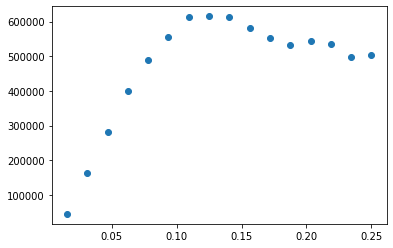

In [22]:
plt.scatter(x,corr_data)
plt.show()